### **Imports and setup** 
Import packages, the config.py and architecture.py files and set global parameters

In [29]:
from config import (
    LEARNING_RATE,
    NUM_EPOCHS,
    TRAIN_SIZE,
    FP_BITS,
    FP_RADIUS,
    list_node_features,
    list_edge_features,
    BATCH_SIZE,
    NUM_ESTIMATORS,
    num_node_features,
    num_edge_features
)
from pkasolver.constants import SEED, DEVICE
from pkasolver.data import (
    load_data,
    preprocess_all,
    train_validation_set_split,
    make_stat_variables,
    make_pyg_dataset_from_dataframe,
    slice_list,  
    cross_val_lists,
    
)
from pkasolver.ml_architecture import (
    GCNProt,
    NNConvProt,
    GCNAttpoolProt,
    GCNDeprot,
    NNConvDeprot,
    GCNAttpoolDeprot,
    GCNPair,
    NNConvPair,
    GCNAttpoolPair,
    NNConvAttpoolProt,
    NNConvAttpoolDeprot,
    NNConvAttpoolPair,
    gcn_full_training
)
from pkasolver.chem import generate_morgan_fp_array, calculate_tanimoto_coefficient
from pkasolver.ml import dataset_to_dataloader, test_ml_model, test_graph_model
from pkasolver.stat import compute_stats, calc_importances, compute_kl_divergence
from captum.attr import IntegratedGradients
import random
import os
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import matplotlib.pyplot as plt
import pickle

plt.rcParams["figure.figsize"] = (6.25, 6.25)
sns.set_theme(style="ticks")

from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from IPython.display import display

import torch
from torch import optim
from rdkit.Chem import Draw, Mol
random.seed(SEED)
imgdir = "images_and_tables"
os.makedirs(imgdir, exist_ok=True)

## **Data Preprocessing**

#### **Import raw data**
Load data from sdf files, create conjugate molescules and store them in pandas DataFrames

Loading data ...
dict_keys(['Training', 'Novartis', 'Literature', 'train_split', 'val_split'])


,pKa,marvin_pKa,marvin_atom,marvin_pKa_type,ISO_SMI,ID,smiles,protonated,deprotonated,Similarity_max
0,8.55,5.34,13,basic,Brc1ccc(C2CN3C=CSC3=[NH+]2)cc1,pka_pot_352_1,Brc1ccc(C2CN3C=CSC3=[NH+]2)cc1,,,0.340426

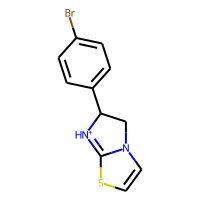
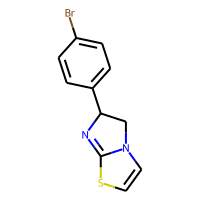

In [36]:
# make sure the directory for saving the run data exists 
# run_data stores pickle files of the dicts containing dataset-Dataframes, morgan fingerprints and pyG graphs)
run_filename = "run_data"
os.makedirs(f"{run_filename}/", exist_ok=True)

# check if saved dictonary of dataset-Dataframes is available and if so, import it
if os.path.isfile(f"{run_filename}/dataset_dfs.pkl"):
    print("Loading data ...")
    with open(f"{run_filename}/dataset_dfs.pkl", "rb") as pickle_file:
        dataset_dfs = pickle.load(pickle_file)

# create DataFrames for each dataset, store them in a dictonary and save it as as .pkl file in in the run_data folder
else:
    print("Generating data ...")
    sdf_paths = load_data("../../data/Baltruschat/")
    dataset_dfs = preprocess_all(sdf_paths) # load all datasets in Dataframes and calculate protonated and deprotonated conjugates
    dataset_dfs["train_split"], dataset_dfs["val_split"] = train_validation_set_split(
        dataset_dfs["Training"], TRAIN_SIZE, SEED
    ) # take a copy of the "Training" dataset, shuffle and split it into train and validation datasets and store them as Dataframe in respective dict   

    with open(f"{run_filename}/dataset_dfs.pkl", "wb") as pickle_file:
        pickle.dump(dataset_dfs, pickle_file)

# notification
print(dataset_dfs.keys())
display(dataset_dfs["Novartis"].head(1))

# **Calulate fingerprint based data**
Create Fingerprints, target-value objects and add best tanimoto similarities of fps form external validation set molecules with those of the train molecules

In [34]:
# check if saved dictonary of fingerprint data is available and if so, import it
if os.path.isfile(f"{run_filename}/fp_data.pkl"):
    with open(f"{run_filename}/fp_data.pkl", "rb") as pickle_file:
        fp_data = pickle.load(pickle_file)

# create fingerprint arrays (dim: num molecules x fp bits) for each dataset, store them in a dictonary and save it as as .pkl file in in the run_data folder
else:
    fp_data = {}
    for name, df in dataset_dfs.items():
        X_feat, y = make_stat_variables(df, [], ["pKa"])
        X_prot = generate_morgan_fp_array(
            df, "protonated", nBits=FP_BITS, radius=FP_RADIUS, useFeatures=True
        )
        X_deprot = generate_morgan_fp_array(
            df, "deprotonated", nBits=FP_BITS, radius=FP_RADIUS, useFeatures=True
        )
        X = np.concatenate((X_prot, X_deprot), axis=1)
        fp_data[f"{name}"] = {"prot": X_prot, "deprot": X_deprot, "pair": X, "y": y}

    with open(f"{run_filename}/fp_data.pkl", "wb") as f:
        pickle.dump(fp_data, f)

# add max tanimotosimilarity to the Dataframes of external test sets
    train_name = "train_split"
    val_name = "val_split"
    Training_name = "Training"
    for name, dataset in fp_data.items():
        if name in [train_name, val_name, Training_name]:
            pass
        else:
            print(f"calculating similarities for {name}")
            max_scores = []
            for test_mol in dataset["prot"]:
                scores = []
                for ref_mol in fp_data[train_name]["prot"]:
                    scores.append(calculate_tanimoto_coefficient(test_mol, ref_mol))
                max_scores.append(max(scores))
            dataset_dfs[name]["Similarity_max"] = max_scores

with open(f"{run_filename}/dataset_dfs.pkl", "wb") as f:
    pickle.dump(dataset_dfs, f)

# notification
print("fp_data keys:", fp_data.keys())
print(f"calculated/loaded fingerprint data successfully")

calculating similarities for Novartis
calculating similarities for Literature
fp_data keys: dict_keys(['Training', 'Novartis', 'Literature', 'train_split', 'val_split'])
calculated/loaded fingerprint data successfully


# **Calculate graph data**
Create graph data with node and edge features specified in the config file and prepare loaders

In [20]:
# check if saved dictonary of graph data is available and if so, import it
if os.path.isfile(f"{run_filename}/graph_data.pkl"):
    print("Loading data ...")
    with open(f"{run_filename}/graph_data.pkl", "rb") as f:
        graph_data = pickle.load(f)

# create list of 'PairData' graph objects for each dataset, store them in a dictonary and save it as as .pkl file in in the run_data folder
else:
    print("Generating data ...")
    graph_data = {}
    for name, df in dataset.items():
        print(f"Generating data for: {name}")
        graph_data[name] = make_pyg_dataset_from_dataframe(
            df, list_node_features, list_edge_features, paired=True
        )
    with open(f"{run_filename}/graph_data.pkl", "wb") as f:
        pickle.dump(graph_data, f)

print("graph_data keys:", graph_data.keys())

# create an iterable loader object from the list of graph data of each dataset and store them in a dictonary
loaders = {}
for name, dataset in graph_data.items():
    print(f"Generating loader for {name}")
    if name == "Training":
        print("Skipping unsplit Training dataset")
        continue
    elif name == "train_split":
        loaders[name] = dataset_to_dataloader(dataset, BATCH_SIZE, shuffle=True) # Shuffling is essential to avoid overfitting on particular batches
    else:
        loaders[name] = dataset_to_dataloader(dataset, BATCH_SIZE, shuffle=False) # Testsets must not be shuffled in order to be able to calculate per datapoint predcitons with all graph and baselinemodels in the analysis part

# notification
print("loaders keys:", loaders.keys())
print(f"calculated/loaded graph data successfully")

Loading data ...
graph_data keys: dict_keys(['Training', 'Novartis', 'Literature', 'train_split', 'val_split'])
Generating loader for Training
Skipping unsplit Training dataset
Generating loader for Novartis
Generating loader for Literature
Generating loader for train_split
Generating loader for val_split
loaders keys: dict_keys(['Novartis', 'Literature', 'train_split', 'val_split'])
calculated/loaded graph data successfully


**show feature value range**

In [21]:
# print all possible node feature values
values = [set() for i in range(len(list_node_features))]
for dataset in graph_data.values():
    for entry in dataset:
        for i, row in enumerate(entry.x_p.cpu().T):
            values[i] = values[i] | set(row.numpy())
        for i, row in enumerate(entry.x_d.cpu().T):
            values[i] = values[i] | set(row.numpy())
print("Node features:")
for name, values in zip(list_node_features, values):
    x = list(values)
    x.sort()
    print(f"{name}:{x}")
print("\n")

# print all possible edge feature values
values = [set() for i in range(len(list_edge_features))]
for dataset in graph_data.values():
    for entry in dataset:
        for i, row in enumerate(entry.edge_attr_p.cpu().T):
            values[i] = values[i] | set(row.numpy())
        for i, row in enumerate(entry.edge_attr_d.cpu().T):
            values[i] = values[i] | set(row.numpy())
print("Edge features:")
for name, values in zip(list_edge_features, values):
    x = list(values)
    x.sort()
    print(f"{name}:{x}")



Node features:
atomic_number:[1.0, 6.0, 7.0, 8.0, 9.0, 15.0, 16.0, 17.0, 33.0, 35.0, 53.0]
formal_charge:[-1.0, 0.0, 1.0]
hybridization:[1.0, 2.0, 3.0, 4.0]
total_num_Hs:[0.0, 1.0, 2.0, 3.0]
aromatic_tag:[0.0, 1.0]
total_valence:[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
total_degree:[1.0, 2.0, 3.0, 4.0]
is_in_ring:[0.0, 1.0]


Edge features:
bond_type:[1.0, 1.5, 2.0, 3.0]
is_conjugated:[0.0, 1.0]
rotatable:[0.0, 1.0]


# **Training of predictive models**

## **train baseline models**
train all baseline models in protonated, deprotonated and pair mode

In [6]:
models_dict = {
    "RFR": RandomForestRegressor(
        n_estimators=NUM_ESTIMATORS, random_state=SEED
    ),  # Baltruschat n_estimatores = 1000
    "PLS": PLSRegression(),
}

baseline_models = {}
train_name = "train_split"
val_name = "val_split"

for model_name, model_template in models_dict.items():
    baseline_models[model_name] = {}
    for mode, X in fp_data[train_name].items():
        if mode == "y":
            continue
        path = f"models/baseline/{model_name}/{mode}/"
        if os.path.isfile(path + "model.pkl"):
            with open(path + "model.pkl", "rb") as pickle_file:
                baseline_models[model_name][mode] = pickle.load(pickle_file)
        else:
            print(f"Training {model_name}_{mode}...")
            y = fp_data[train_name]["y"]
            y_val = fp_data[val_name]["y"]
            model = copy.deepcopy(model_template)
            model.fit(X, y)
            print(f"{model_name}_{mode}: {model.score(fp_data[val_name][mode], y_val)}")
            baseline_models[model_name][mode] = model
            os.makedirs(path, exist_ok=True)
            with open(path + "model.pkl", "wb") as pickle_file:
                pickle.dump(model, pickle_file)
print(f"trained/loaded baseline models successfully")

trained/loaded baseline models successfully


# **Train graph models**

## **Training**
train all graph models in protonated, deprotonated and pair mode

In [7]:
embedding_size = 96
num_graph_layer = 4
num_linear_layer = 2

gcn_dict = {
    "prot": {"no-edge": GCNProt, "edge": NNConvProt,"att":GCNAttpoolProt, "att_edge": NNConvAttpoolProt},
    "deprot": {"no-edge": GCNDeprot, "edge": NNConvDeprot, "att":GCNAttpoolDeprot, "att_edge":NNConvAttpoolDeprot},
    "pair": {"no-edge": GCNPair, "edge": NNConvPair, "att":GCNAttpoolPair, "att_edge":NNConvAttpoolPair},
}

# mol_modes = ["pair"]
mol_modes = ["prot", "deprot", "pair"]
edge_modes = ["no-edge", "edge", "att", "att_edge"]
# edge_modes = ["att"]

graph_models = {}
for mode in mol_modes:
    graph_models[mode] = {}
    for edge in edge_modes:
        path = f"models/gcn/{mode}/{edge}/"

        if os.path.isfile(path + "model.pkl"):
            with open(path + "model.pkl", "rb") as pickle_file:
                graph_models[mode][edge] = pickle.load(pickle_file)
            model = graph_models[mode][edge]
        else:
            try: 
                model = gcn_dict[mode][edge](96, 4, 2, num_node_features, num_edge_features)
                graph_models[mode][edge] = model
                os.makedirs(path, exist_ok=True)
            except:
                pass

        if model.checkpoint["epoch"] < NUM_EPOCHS:
            model.to(device=DEVICE)
            print(model.checkpoint["epoch"])
            optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
            print("Number of parameters: ", sum(p.numel() for p in model.parameters()))            
            try:
                optimizer.load_state_dict(model.checkpoint["optimizer_state"])
            except:
                pass
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, patience=5, verbose=True
            )

            print(
                f'Training GCN_{mode} with {edge} at epoch {model.checkpoint["epoch"]}...'
            )
            print(model)
            print(f'Training on {DEVICE}.')
            gcn_full_training(
                model.to(device=DEVICE),
                loaders["train_split"],
                loaders["val_split"],
                optimizer,
                path,
                NUM_EPOCHS,
            )

            with open(path + "model.pkl", "wb") as pickle_file:
                pickle.dump(model.to(device='cpu'), pickle_file)
print(f"trained/loaded gcn models successfully")

4001
Number of parameters:  38209
Training GCN_prot with no-edge at epoch 4001...
GCNProt(
  (convs): ModuleList(
    (0): GCNConv(8, 96)
    (1): GCNConv(96, 96)
    (2): GCNConv(96, 96)
    (3): GCNConv(96, 96)
  )
  (lin): ModuleList(
    (0): Linear(in_features=96, out_features=96, bias=True)
    (1): Linear(in_features=96, out_features=1, bias=True)
  )
)
Training on cuda.


Epoch: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


4001
Number of parameters:  208065
Training GCN_prot with edge at epoch 4001...
NNConvProt(
  (convs): ModuleList(
    (0): NNConv(8, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=768, bias=True)
    ))
    (1): NNConv(96, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=9216, bias=True)
    ))
    (2): NNConv(96, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=9216, bias=True)
    ))
    (3): NNConv(96, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=9216, bias=True)
    ))
  )
  (lin): ModuleList(
    (0): Linear(in_features=96, out_features=96, bias=True

Epoch: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


4001
Number of parameters:  39906
Training GCN_prot with att at epoch 4001...
GCNAttpoolProt(
  (convs): ModuleList(
    (0): GCNConv(8, 96)
    (1): GCNConv(96, 96)
    (2): GCNConv(96, 96)
    (3): GCNConv(96, 96)
  )
  (lin): ModuleList(
    (0): Linear(in_features=104, out_features=104, bias=True)
    (1): Linear(in_features=104, out_features=1, bias=True)
  )
  (pool): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  ), nn=None)
)
Training on cuda.


Epoch: 100%|██████████| 3/3 [00:23<00:00,  7.71s/it]


4001
Number of parameters:  209762
Training GCN_prot with att_edge at epoch 4001...
NNConvAttpoolProt(
  (convs): ModuleList(
    (0): NNConv(8, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=768, bias=True)
    ))
    (1): NNConv(96, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=9216, bias=True)
    ))
    (2): NNConv(96, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=9216, bias=True)
    ))
    (3): NNConv(96, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=9216, bias=True)
    ))
  )
  (lin): ModuleList(
    (0): Linear(in_features=104, out_features=1

Epoch: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


4001
Number of parameters:  38209
Training GCN_deprot with no-edge at epoch 4001...
GCNDeprot(
  (convs): ModuleList(
    (0): GCNConv(8, 96)
    (1): GCNConv(96, 96)
    (2): GCNConv(96, 96)
    (3): GCNConv(96, 96)
  )
  (lin): ModuleList(
    (0): Linear(in_features=96, out_features=96, bias=True)
    (1): Linear(in_features=96, out_features=1, bias=True)
  )
)
Training on cuda.


Epoch: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


4001
Number of parameters:  208065
Training GCN_deprot with edge at epoch 4001...
NNConvDeprot(
  (convs): ModuleList(
    (0): NNConv(8, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=768, bias=True)
    ))
    (1): NNConv(96, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=9216, bias=True)
    ))
    (2): NNConv(96, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=9216, bias=True)
    ))
    (3): NNConv(96, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=9216, bias=True)
    ))
  )
  (lin): ModuleList(
    (0): Linear(in_features=96, out_features=96, bias=

Epoch: 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


4001
Number of parameters:  39906
Training GCN_deprot with att at epoch 4001...
GCNAttpoolDeprot(
  (convs): ModuleList(
    (0): GCNConv(8, 96)
    (1): GCNConv(96, 96)
    (2): GCNConv(96, 96)
    (3): GCNConv(96, 96)
  )
  (lin): ModuleList(
    (0): Linear(in_features=104, out_features=104, bias=True)
    (1): Linear(in_features=104, out_features=1, bias=True)
  )
  (pool): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  ), nn=None)
)
Training on cuda.


Epoch: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


4001
Number of parameters:  209762
Training GCN_deprot with att_edge at epoch 4001...
NNConvAttpoolDeprot(
  (convs): ModuleList(
    (0): NNConv(8, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=768, bias=True)
    ))
    (1): NNConv(96, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=9216, bias=True)
    ))
    (2): NNConv(96, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=9216, bias=True)
    ))
    (3): NNConv(96, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=9216, bias=True)
    ))
  )
  (lin): ModuleList(
    (0): Linear(in_features=104, out_featur

Epoch: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


4001
Number of parameters:  94849
Training GCN_pair with no-edge at epoch 4001...
GCNPair(
  (convs_p): ModuleList(
    (0): GCNConv(8, 96)
    (1): GCNConv(96, 96)
    (2): GCNConv(96, 96)
    (3): GCNConv(96, 96)
  )
  (convs_d): ModuleList(
    (0): GCNConv(8, 96)
    (1): GCNConv(96, 96)
    (2): GCNConv(96, 96)
    (3): GCNConv(96, 96)
  )
  (lin): ModuleList(
    (0): Linear(in_features=192, out_features=192, bias=True)
    (1): Linear(in_features=192, out_features=1, bias=True)
  )
)
Training on cuda.


Epoch: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


4001
Number of parameters:  434561
Training GCN_pair with edge at epoch 4001...
NNConvPair(
  (convs_d): ModuleList(
    (0): NNConv(8, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=768, bias=True)
    ))
    (1): NNConv(96, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=9216, bias=True)
    ))
    (2): NNConv(96, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=9216, bias=True)
    ))
    (3): NNConv(96, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=9216, bias=True)
    ))
  )
  (convs_p): ModuleList(
    (0): NNConv(8, 96, aggr="add", nn=Sequential(
  

Epoch: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


4001
Number of parameters:  101443
Training GCN_pair with att at epoch 4001...
GCNAttpoolPair(
  (convs_p): ModuleList(
    (0): GCNConv(8, 96)
    (1): GCNConv(96, 96)
    (2): GCNConv(96, 96)
    (3): GCNConv(96, 96)
  )
  (convs_d): ModuleList(
    (0): GCNConv(8, 96)
    (1): GCNConv(96, 96)
    (2): GCNConv(96, 96)
    (3): GCNConv(96, 96)
  )
  (lin): ModuleList(
    (0): Linear(in_features=208, out_features=208, bias=True)
    (1): Linear(in_features=208, out_features=1, bias=True)
  )
  (pool_p): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  ), nn=None)
  (pool_d): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  ), nn=None)
)
Training on cuda.


Epoch: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


4001
Number of parameters:  441155
Training GCN_pair with att_edge at epoch 4001...
NNConvAttpoolPair(
  (convs_d): ModuleList(
    (0): NNConv(8, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=768, bias=True)
    ))
    (1): NNConv(96, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=9216, bias=True)
    ))
    (2): NNConv(96, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=9216, bias=True)
    ))
    (3): NNConv(96, 96, aggr="add", nn=Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=9216, bias=True)
    ))
  )
  (convs_p): ModuleList(
    (0): NNConv(8, 96, aggr="add", nn=Seq

Epoch: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


trained/loaded gcn models successfully


In [8]:
epoch_treshold = 4000
mol_modes=['prot','deprot','pair']
# mol_modes=['prot']
edge_modes=['no-edge','edge', 'att', 'att_edge']

In [9]:
graph_models = {}
for mode in mol_modes:
    graph_models[mode] ={}
    for edge in edge_modes:
        graph_models[mode][edge] = {} 
        path = f'models/gcn/{mode}/{edge}/'
        if os.path.isfile(path+'model.pkl'):
            with open(path+'model.pkl', 'rb') as pickle_file:
                model = pickle.load(pickle_file)
            model.to(device='cpu')
            best_loss = max([x for x in model.checkpoint['best_states'].keys() if x < epoch_treshold]) 
            model.load_state_dict(model.checkpoint['best_states'][best_loss][1])
            loss = model.checkpoint['best_states'][best_loss][0]
            print(f'GCN_{mode}_{edge},Epoch {best_loss}, Loss:{loss}')
            graph_models[mode][edge] = model
        else:
            print(f'{path} not found')

GCN_prot_no-edge,Epoch 3520, Loss:0.672
GCN_prot_edge,Epoch 1160, Loss:0.594
GCN_prot_att,Epoch 3560, Loss:0.699
GCN_prot_att_edge,Epoch 2520, Loss:0.581
GCN_deprot_no-edge,Epoch 1600, Loss:0.686
GCN_deprot_edge,Epoch 1040, Loss:0.595
GCN_deprot_att,Epoch 2880, Loss:0.671
GCN_deprot_att_edge,Epoch 3880, Loss:0.597
GCN_pair_no-edge,Epoch 3960, Loss:0.605
GCN_pair_edge,Epoch 1320, Loss:0.552
GCN_pair_att,Epoch 3000, Loss:0.601
GCN_pair_att_edge,Epoch 1120, Loss:0.552


In [10]:
#Predictions of baseline and graph models

for i,test_set in enumerate(['Novartis', 'Literature', 'val_split']):

    df_ml = test_ml_model(baseline_models, fp_data[test_set], fp_data[test_set]['y'],test_set)
    df_gcn = test_graph_model(graph_models, loaders[test_set],test_set)
    df= pd.concat([df_ml.drop(columns=['Dataset', 'pKa_true']),df_gcn],axis=1)
    df= pd.concat([df_gcn],axis=1)
    torch.cuda.empty_cache()
    if i == 0:
        df_res = df
    else:
        df_res = pd.concat([df_res,df])
display(df_res)

,Dataset,pKa_true,GCN_prot_no-edge,GCN_prot_edge,GCN_prot_att,GCN_prot_att_edge,GCN_deprot_no-edge,GCN_deprot_edge,GCN_deprot_att,GCN_deprot_att_edge,GCN_pair_no-edge,GCN_pair_edge,GCN_pair_att,GCN_pair_att_edge
0,Novartis,8.55,8.381893,8.334948,8.367914,8.312010,8.655888,7.084131,9.129708,9.009542,9.087852,7.489544,7.862291,6.038107
1,Novartis,5.50,6.971861,6.472386,5.623891,6.578594,8.124084,7.657986,8.500710,6.008678,6.338198,7.303508,6.627988,6.497626
2,Novartis,4.50,6.412648,6.420982,5.234554,6.327611,7.399499,6.552917,8.339655,7.667753,5.773767,6.982590,6.550409,7.177232
3,Novartis,5.50,7.315796,6.678543,5.541436,6.301080,7.774360,7.126913,8.740870,7.277529,6.797386,7.222934,7.175816,6.479159
4,Novartis,5.00,5.269186,5.489721,4.011143,5.245953,6.427301,6.254694,8.312512,5.493276,5.247064,6.409462,5.537776,6.046189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,val_split,10.30,10.118963,9.966343,9.561849,9.900133,9.822433,9.677396,9.844954,9.920318,10.007111,9.735009,9.752938,9.726200
1195,val_split,9.72,7.566867,9.753327,6.804227,10.164782,6.611550,9.006448,5.215583,10.234514,7.392789,9.851753,6.555342,9.577982
1196,val_split,10.60,9.111658,9.740204,8.530742,10.117254,9.256203,10.627854,9.445989,9.661608,9.870898,9.252833,10.021787,9.727564
1197,val_split,9.00,9.164086,9.145410,7.518530,9.316909,8.312304,10.659640,9.254397,9.122397,9.028705,8.940935,9.533095,9.705441


In [11]:
test= compute_stats(df_res, 'Dataset', 'pKa_true')
test.to_csv(f'{imgdir}/stat_metrics.csv')
display(test)

Novartis               Literature               val_split  \
                         R^2   RMSE    MAE        R^2   RMSE    MAE       R^2   
GCN_prot_no-edge       0.645  1.372  1.062      0.905  0.727  0.526     0.814   
GCN_prot_edge          0.697  1.268  1.004      0.913  0.697  0.495     0.851   
GCN_prot_att           0.612  1.435  1.061      0.889  0.785  0.515     0.811   
GCN_prot_att_edge      0.643  1.376  1.024      0.886  0.798  0.545     0.854   
GCN_deprot_no-edge     0.658  1.347  1.016      0.921  0.665  0.466     0.819   
GCN_deprot_edge        0.715  1.230  0.979      0.913  0.694  0.493     0.857   
GCN_deprot_att         0.681  1.301  0.987      0.887  0.793  0.591     0.826   
GCN_deprot_att_edge    0.654  1.355  1.043      0.914  0.692  0.484     0.854   
GCN_pair_no-edge       0.743  1.168  0.888      0.927  0.639  0.474     0.849   
GCN_pair_edge          0.734  1.188  0.908      0.933  0.611  0.441     0.870   
GCN_pair_att           0.706  1.249  0.943      0.918  0.677  0.472     0.860   
GCN_pair_att_edge      0.712  1.236  0.956      0.909  0.711  0.509     0.868   

                                   
                      RMSE    MAE  
GCN_prot_no-edge     1.033  0.674  
GCN_prot_edge        0.923  0.595  
GCN_prot_att         1.041  0.699  
GCN_prot_att_edge    0.914  0.581  
GCN_deprot_no-edge   1.018  0.687  
GCN_deprot_edge      0.906  0.594  
GCN_deprot_att       0.997  0.673  
GCN_deprot_att_edge  0.916  0.599  
GCN_pair_no-edge     0.930  0.603  
GCN_pair_edge        0.863  0.551  
GCN_pair_att         0.894  0.602  
GCN_pair_att_edge    0.870  0.550

Plot best model
Plot the predictions of the best models for the validation and the two testsets

In [12]:
def plot_results(df, x_column, y_column):
    y = df[x_column]
    y_hat = df[y_column]
    stat_info = f"""
        $r^2$ = {r2_score(y, y_hat): .2f}
        $MAE$ = {mean_absolute_error(y, y_hat): .2f}
        $RMSE$ = {mean_squared_error(y, y_hat): .2f}
        $kl_div$ = {compute_kl_divergence(y_hat,y): .2f}
        """
        # r² = 0.78 [0.74, 0.81]
    g = sns.JointGrid(data=df, x=x_column, y=y_column, xlim=(2,12), ylim=(2,12), height=3.125)
    g.plot_joint(sns.regplot)
    
    g.plot_marginals(sns.kdeplot, shade=True)
    g.ax_joint.text(0, 1, stat_info, size='x-small', ha='left', va="top", transform = g.ax_joint.transAxes)
    return g

/data/shared/projects/pKa-prediction/anaconda3/envs/pkasolver/lib/python3.9/site-packages/seaborn/axisgrid.py:1670: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


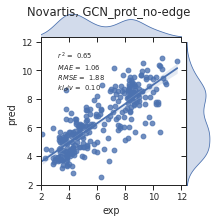

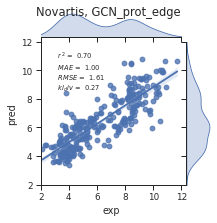

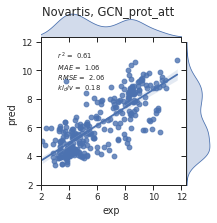

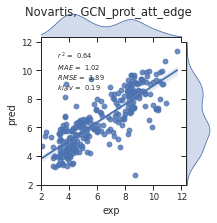

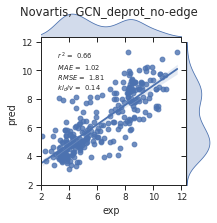

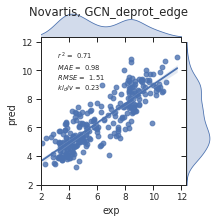

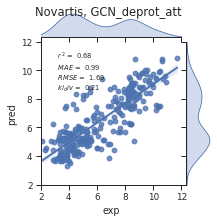

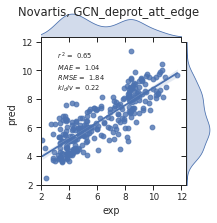

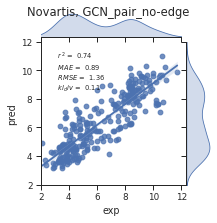

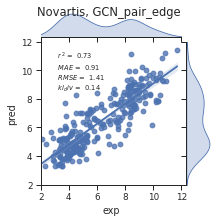

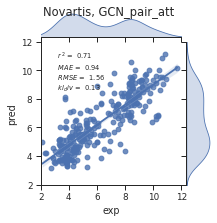

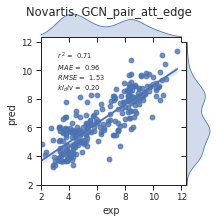

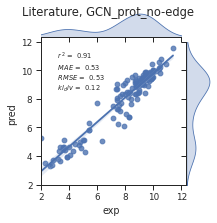

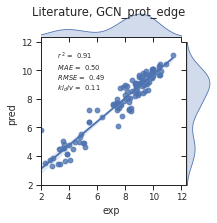

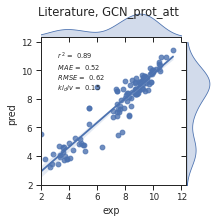

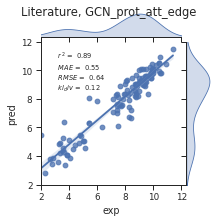

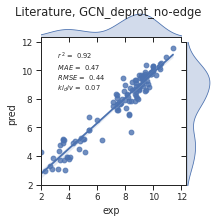

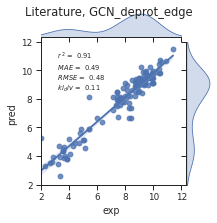

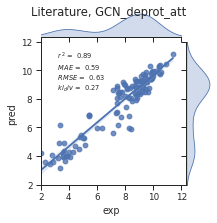

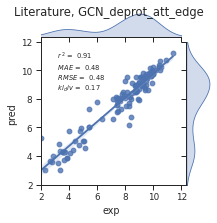

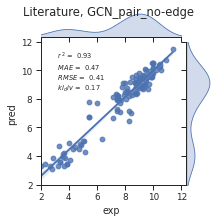

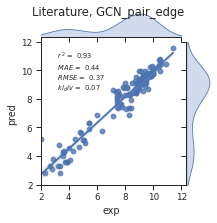

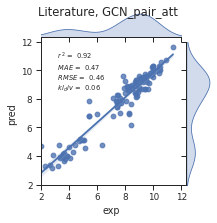

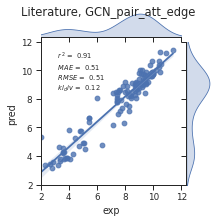

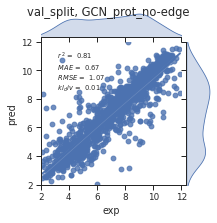

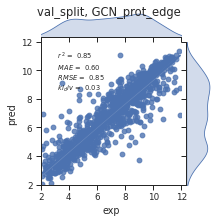

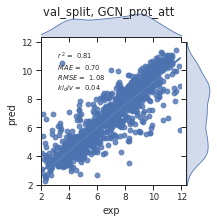

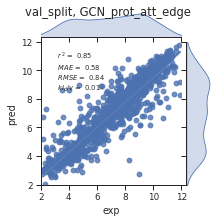

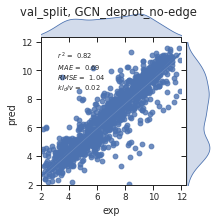

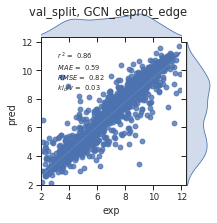

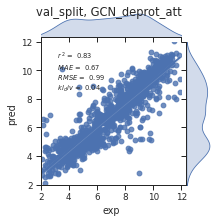

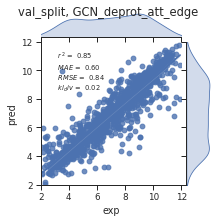

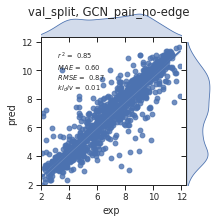

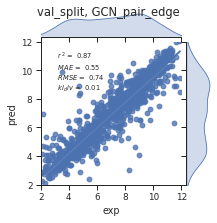

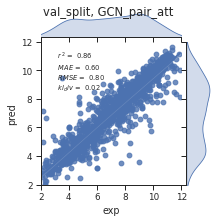

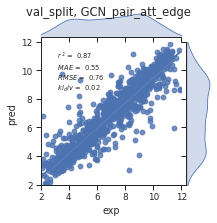

In [13]:
sns.set_context('paper')
d = df_res
# model='GCN_prot_edge'
for dataset in d['Dataset'].unique():
    for model in df.columns.drop(["pKa_true", "Dataset"]):
# for dataset, model in zip(['Novartis','Literature'],['GCN_pair_edge', 'GCN_deprot_no-edge']):
        g = plot_results(d[d['Dataset']== dataset], 'pKa_true', model)
        g.set_axis_labels('exp', 'pred')
        g.fig.suptitle(f'{dataset}, {model}')
        plt.savefig(f'{imgdir}/regression_{dataset}_{model}.pdf', bbox_inches='tight')
# plt.show()
    
#     plt.figure(figsize=(3.125,3.125))
#     sns.residplot(data=df_res[df_res['Dataset']==dataset],x='pKa_true', y=model, lowess=True)
#     plt.ylabel('Error')
# #     plt.title('gcn_pair_edge')
    # plt.savefig(f'{imgdir}/residuals_{dataset}_gcn_pair_edge.pdf', bbox_inches='tight')

GCN training progress

store training losses in DataFrame and

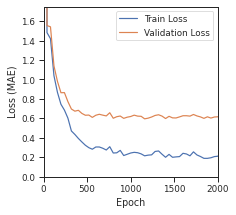

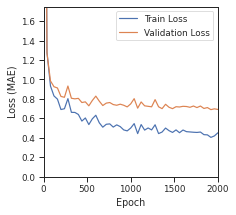

In [14]:
for x,y in list([['prot','edge'],['prot','no-edge']]):
    df_prog=pd.DataFrame(graph_models[x][y].checkpoint['progress_table'])
#     df_prog=pd.DataFrame(graph_models_cv[x][y][1].checkpoint['progress_table'])
    #plot learning
    fig, ax = plt.subplots()
    fig.set_size_inches(3.125,3.125)
    sns.lineplot(x='epoch',y='train_loss', label='Train Loss',data=df_prog,ax=ax)
    sns.lineplot(x='epoch',y='test_loss',label='Validation Loss',data=df_prog,ax=ax)
    ax.set_ylabel("Loss (MAE)")
    ax.set_xlabel("Epoch")
    ax.set_xlim(left=0, right=2000)
    ax.set_ylim(top=1.75, bottom=0)
#     plt.title(f'training progress of gcn_{x}_{y} model')
    plt.savefig(f'{imgdir}/training_progress_gcn_{x}_{y}.pdf',bbox_inches='tight')
    plt.show()


Feature impact

Importances of gcn_prot_edge'

In [22]:
# def boxplot(attr_data):
#     plt.figure(figsize=(3.125,6.25))
#     sns.boxplot(x="value", y="variable",
#                 orient="h",
#                 data=attr_data,
#                 whis=[0, 100], width=.6)

#     # Add in points to show each observation
#     sns.stripplot(x="value", y="variable",
#                 orient="h",
#                 data=attr_data,
#                 size=4, color=".3", linewidth=0)
#     plt.ylabel('')

# # types = ['prot','deprot','pair']
# types = ['prot']
# f_modes= ['no-edge','edge']
# for data_type in types:
#     for f_mode in f_modes: 
#         model = graph_models[data_type][f_mode]
#         dataset = graph_data['train_split']
#         ig = IntegratedGradients(model)
#         attr_pre_df = calc_importances(ig, dataset, 100, list_node_features, list_edge_features) #adjust number of random samples

#         attr_pre_df.iloc[:, 1:]=attr_pre_df.iloc[:, 1:].abs()
#         attr_df=attr_pre_df.groupby('ID').max()
#         attr_data = pd.melt(attr_df)
        
#         if data_type== 'pair':
#             split = len(attr_data.variable.unique())//2
#             attr_data1 = pd.melt(attr_df.iloc[:,0:split])
#             attr_data2 = pd.melt(attr_df.iloc[:,split:])
        
#             boxplot(attr_data1)
# #             plt.title(f'gcn_{data_type}_1_{f_mode}')
#             plt.savefig(f'{imgdir}/importances_{data_type}_1_{f_mode}.pdf', bbox_inches='tight')
#             plt.show()
#             boxplot(attr_data2)
# #             plt.title(f'gcn_{data_type}_2_{f_mode}')
#             plt.savefig(f'{imgdir}/importances_{data_type}_2_{f_mode}.pdf', bbox_inches='tight')
#             plt.show()
            
#         else:
#             boxplot(attr_data)
# #             plt.title(f'gcn_{data_type}_{f_mode}')
#             plt.savefig(f'{imgdir}/importances_{data_type}_{f_mode}.pdf', bbox_inches='tight')
#             plt.show()

Metrics by tanimoto similarity

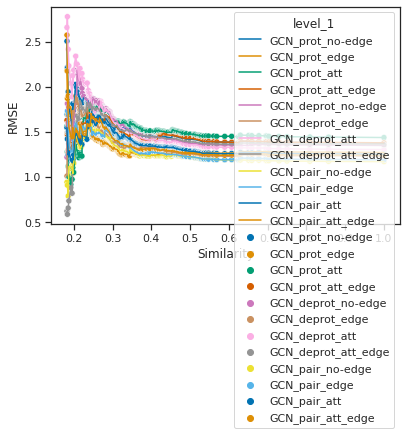

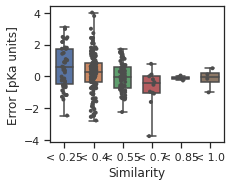

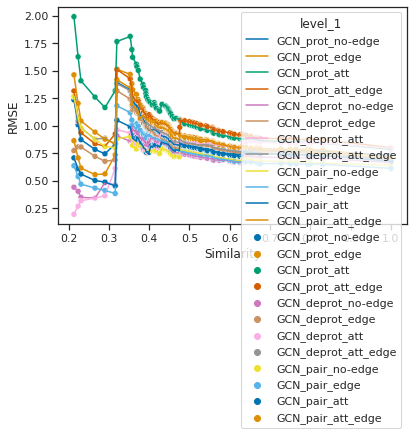

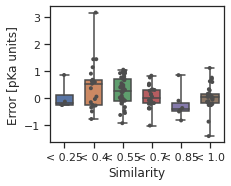

In [40]:
x1= pd.concat([df_res[['Dataset', 'pKa_true']],df_res.loc[:,(df_res.columns.str.startswith('GCN'))]],axis=1)
for data_set in ['Novartis', 'Literature']:
    df = x1[x1['Dataset']==data_set].copy()
    df['similarity'] = dataset_dfs[data_set].loc[:,'Similarity_max']
    df.sort_values(by=['similarity'], inplace=True)

    res=[]
    tanimoto=[]
    maximum=0

    for i in range(2,len(df)):
        df2 = df.iloc[:i,:]
        new_maximum = df2['similarity'].max()
        if new_maximum <= maximum:
            tanimoto[-1]= new_maximum
            res[-1]= compute_stats(df2, 'Dataset', 'pKa_true',col_exclude=['similarity'])
        else: 
            tanimoto.append(new_maximum)
            res.append(compute_stats(df2, 'Dataset', 'pKa_true', col_exclude=['similarity']))
        maximum=new_maximum
    result = pd.concat((res), keys=tanimoto)
    result

    # X=result['Novartis'].loc[(slice(None),'pKa_gcn_prot_edge'),:].reset_index()
    X=result[data_set].reset_index()
    plt.figure(figsize=(6.25,4))
    # ax = sns.scatterplot(x='level_0', y="RMSE", hue='level_1', palette='colorblind', data=X)
    ax = sns.lineplot(x='level_0', y="RMSE", hue='level_1', marker=True, palette='colorblind', data=X)
    legend = ax.legend()
    legend.texts[0] = ''
    
    plt.xlabel('Similarity')
    plt.savefig(f'{imgdir}/RMSE_sim_{data_set}.pdf')
    
    x2= x1
    df = x2[x2['Dataset']==data_set].copy()
    df['similarity'] = dataset_dfs[data_set].loc[:,'Similarity_max']
    df.sort_values(by=['similarity'], inplace=True)
    
    df = df.loc[:,('pKa_true','GCN_pair_edge','similarity')]

    df['Error']= df['GCN_pair_edge']-df['pKa_true']

    sims=[]
    step_size=0.15
    for sim in df['similarity']:
        x=1
        while sim < x:
            x+= -step_size
        sims.append(f'< {round(np.clip(x+step_size,0,1),3)}')
    df['group']=sims            

    plt.figure(figsize=(6.25/2,2.5))
    sns.boxplot(x="group", y="Error",
                orient="v",

                whis=[0, 100], width=.6,
                data=df
               )
    # Add in points to show each observation
    sns.stripplot(x="group", y="Error",
                orient="v",
                data=df,
                  size=4, color=".3", linewidth=0)
    plt.xlabel('Similarity')
    plt.ylabel('Error [pKa units]')
    plt.savefig(f'{imgdir}/error_sim_bloxplot_{data_set}.pdf', bbox_inches='tight')


Outliers top list

In [ ]:
def get_2d_molecule(m):
  copy = Mol(m)
  copy.Compute2DCoords(clearConfs=True)
  return copy

def group_by_range(series, range_list, decimal=1):
    group_labels=[]
    for x in series:
        i=0
        while x > range_list[i]:
            i+=1
        group_labels.append(round(range_list[i],decimal))
    return group_labels 

data_set=['Novartis', 'Literature']
best=[True, False]
for data_set in data_set:
    trues= df_res[df_res.Dataset==data_set].pKa_true
    preds= df_res[df_res.Dataset==data_set].GCN_pair_edge
    diffs = []
    errors = []
    for pred, true in zip(preds,trues):
        diffs.append(pred-true)
        errors.append(abs(pred-true))
    res = pd.concat((pd.DataFrame({'differences':diffs}),pd.DataFrame({'errors':errors}), dataset_dfs['Novartis'].loc[:,('pKa','marvin_atom','protonated', 'deprotonated', 'ID','Similarity_max')]),axis=1)
    
    res_e=res.loc[:, ('errors','pKa','Similarity_max')]
    res_e['pKa']=group_by_range(res_e['pKa'],list(range(2,14,2)))
    res_e['Similarity']=group_by_range(res['Similarity_max'],np.arange(0.0,1.2,0.2))
    res_e=res_e.loc[:, ('errors','pKa','Similarity')]
    res_e=res_e.groupby(['Similarity','pKa']).mean().unstack()
#     display(res_e)
    
    plt.figure(figsize=(3.125,2.5))
    sns.heatmap(res_e['errors'], cmap='RdYlGn_r', vmin=0,vmax=1.50)
    plt.savefig(f'{imgdir}/error_heatmap_{data_set}.pdf', bbox_inches='tight')
    plt.show()
    
    for mod in best:    
        res.sort_values(by=['errors'], inplace=True, ascending=mod)
        num=6
        img=Draw.MolsToGridImage(res.protonated[:num].map(get_2d_molecule),
                                 molsPerRow=3,
                                 subImgSize=(400,350),
                                 useSVG=True,
                                 highlightAtomLists=[[int(i)] for i in res.marvin_atom[:num]],
                                 legends=[f"error:  {round(x[1],2)}, pKa:  {x[0]}, sim: {x[2]:.3f}" for x in zip(res.pKa[:num],res.differences[:num], res.Similarity_max[:num])])

        display(img)
        name_dict={True:'best',False:'outlier'}
        with open(f'{imgdir}/grid_{data_set}_{name_dict[mod]}.svg', 'w') as f:
            f.write(img.data)
    # res.head()